The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha1.post0


# Single Variable Calculus
:label:`sec_single_variable_calculus`

In :numref:`sec_calculus`, we saw the basic elements of differential calculus.  This section takes a deeper dive into the fundamentals of calculus and how we can understand and apply it in the context of machine learning.

## Differential Calculus
Differential calculus is fundamentally the study of how functions behave under small changes.  To see why this is so core to deep learning, let's consider an example.

Suppose that we have a deep neural network where the weights are, for convenience, concatenated into a single vector $\mathbf{w} = (w_1, \ldots, w_n)$.  Given a training dataset, we consider the loss of our neural network on this dataset, which we will write as $\mathcal{L}(\mathbf{w})$.

This function is extraordinarily complex, encoding the performance of all possible models of the given architecture on this dataset, so it is nearly impossible to tell what set of weights $\mathbf{w}$ will minimize the loss. Thus, in practice, we often start by initializing our weights *randomly*, and then iteratively take small steps in the direction which makes the loss decrease as rapidly as possible.

The question then becomes something that on the surface is no easier: how do we find the direction which makes the weights decrease as quickly as possible?  To dig into this, let's first examine the case with only a single weight: $L(\mathbf{w}) = L(x)$ for a single real value $x$.

Let's take $x$ and try to understand what happens when we change it by a small amount to $x + \epsilon$. If you wish to be concrete, think a number like $\epsilon = 0.0000001$.  To help us visualize what happens, let's graph an example function, $f(x) = \sin(x^x)$, over the $[0, 3]$.


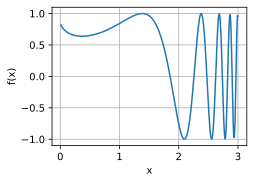

In [1]:
%matplotlib inline
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

tf.pi = tf.acos(tf.zeros(1)).numpy() * 2  # Define pi in TensorFlow

# Plot a function in a normal range
x_big = tf.range(0.01, 3.01, 0.01)
ys = tf.sin(x_big**x_big)
d2l.plot(x_big, ys, 'x', 'f(x)')

At this large scale, the function's behavior is not simple. However, if we reduce our range to something smaller like $[1.75,2.25]$, we see that the graph becomes much simpler.


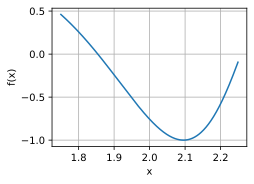

In [2]:
# Plot a the same function in a tiny range
x_med = tf.range(1.75, 2.25, 0.001)
ys = tf.sin(x_med**x_med)
d2l.plot(x_med, ys, 'x', 'f(x)')

Taking this to an extreme, if we zoom into a tiny segment, the behavior becomes far simpler: it is just a straight line.


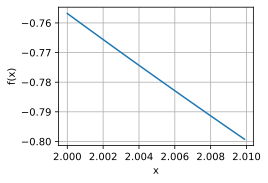

In [3]:
# Plot a the same function in a tiny range
x_small = tf.range(2.0, 2.01, 0.0001)
ys = tf.sin(x_small**x_small)
d2l.plot(x_small, ys, 'x', 'f(x)')

This is the key observation of single variable calculus: the behavior of familiar functions can be modeled by a line in a small enough range.  This means that for most functions, it is reasonable to expect that as we shift the $x$ value of the function by a little bit, the output $f(x)$ will also be shifted by a little bit.  The only question we need to answer is, "How large is the change in the output compared to the change in the input?  Is it half as large?  Twice as large?"

Thus, we can consider the ratio of the change in the output of a function for a small change in the input of the function.  We can write this formally as

$$
\frac{L(x+\epsilon) - L(x)}{(x+\epsilon) - x} = \frac{L(x+\epsilon) - L(x)}{\epsilon}.
$$

This is already enough to start to play around with in code.  For instance, suppose that we know that $L(x) = x^{2} + 1701(x-4)^3$, then we can see how large this value is at the point $x = 4$ as follows.


In [4]:
# Define our function
def L(x):
    return x**2 + 1701*(x-4)**3

# Print the difference divided by epsilon for several epsilon
for epsilon in [0.1, 0.001, 0.0001, 0.00001]:
    print(f'epsilon = {epsilon:.5f} -> {(L(4+epsilon) - L(4)) / epsilon:.5f}')

epsilon = 0.10000 -> 25.11000
epsilon = 0.00100 -> 8.00270
epsilon = 0.00010 -> 8.00012
epsilon = 0.00001 -> 8.00001


Now, if we are observant, we will notice that the output of this number is suspiciously close to $8$.  Indeed, if we decrease $\epsilon$, we will see value becomes progressively closer to $8$.  Thus we may conclude, correctly, that the value we seek (the degree a change in the input changes the output) should be $8$ at the point $x=4$.  The way that a mathematician encodes this fact is

$$
\lim_{\epsilon \rightarrow 0}\frac{L(4+\epsilon) - L(4)}{\epsilon} = 8.
$$

As a bit of a historical digression: in the first few decades of neural network research, scientists used this algorithm (the *method of finite differences*) to evaluate how a loss function changed under small perturbation: just change the weights and see how the loss changed.  This is computationally inefficient, requiring two evaluations of the loss function to see how a single change of one variable influenced the loss.  If we tried to do this with even a paltry few thousand parameters, it would require several thousand evaluations of the network over the entire dataset!  It was not solved until 1986 that the *backpropagation algorithm* introduced in :citet:`Rumelhart.Hinton.Williams.ea.1988` provided a way to calculate how *any* change of the weights together would change the loss in the same computation time as a single prediction of the network over the dataset.

Back in our example, this value $8$ is different for different values of $x$, so it makes sense to define it as a function of $x$.  More formally, this value dependent rate of change is referred to as the *derivative* which is written as

$$\frac{df}{dx}(x) = \lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon) - f(x)}{\epsilon}.$$
:eqlabel:`eq_der_def`

Different texts will use different notations for the derivative. For instance, all of the below notations indicate the same thing:

$$
\frac{df}{dx} = \frac{d}{dx}f = f' = \nabla_xf = D_xf = f_x.
$$

Most authors will pick a single notation and stick with it, however even that is not guaranteed.  It is best to be familiar with all of these.  We will use the notation $\frac{df}{dx}$ throughout this text, unless we want to take the derivative of a complex expression, in which case we will use $\frac{d}{dx}f$ to write expressions like
$$
\frac{d}{dx}\left[x^4+\cos\left(\frac{x^2+1}{2x-1}\right)\right].
$$

Oftentimes, it is intuitively useful to unravel the definition of derivative :eqref:`eq_der_def` again to see how a function changes when we make a small change of $x$:

$$\begin{aligned} \frac{df}{dx}(x) = \lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon) - f(x)}{\epsilon} & \implies \frac{df}{dx}(x) \approx \frac{f(x+\epsilon) - f(x)}{\epsilon} \\ & \implies \epsilon \frac{df}{dx}(x) \approx f(x+\epsilon) - f(x) \\ & \implies f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x). \end{aligned}$$
:eqlabel:`eq_small_change`

The last equation is worth explicitly calling out.  It tells us that if you take any function and change the input by a small amount, the output would change by that small amount scaled by the derivative.

In this way, we can understand the derivative as the scaling factor that tells us how large of change we get in the output from a change in the input.

## Rules of Calculus
:label:`sec_derivative_table`

We now turn to the task of understanding how to compute the derivative of an explicit function.  A full formal treatment of calculus would derive everything from first principles.  We will not indulge in this temptation here, but rather provide an understanding of the common rules encountered.

### Common Derivatives
As was seen in :numref:`sec_calculus`, when computing derivatives one can oftentimes use a series of rules to reduce the computation to a few core functions.  We repeat them here for ease of reference.

* **Derivative of constants.** $\frac{d}{dx}c = 0$.
* **Derivative of linear functions.** $\frac{d}{dx}(ax) = a$.
* **Power rule.** $\frac{d}{dx}x^n = nx^{n-1}$.
* **Derivative of exponentials.** $\frac{d}{dx}e^x = e^x$.
* **Derivative of the logarithm.** $\frac{d}{dx}\log(x) = \frac{1}{x}$.

### Derivative Rules
If every derivative needed to be separately computed and stored in a table, differential calculus would be near impossible.  It is a gift of mathematics that we can generalize the above derivatives and compute more complex derivatives like finding the derivative of $f(x) = \log\left(1+(x-1)^{10}\right)$.  As was mentioned in :numref:`sec_calculus`, the key to doing so is to codify what happens when we take functions and combine them in various ways, most importantly: sums, products, and compositions.

* **Sum rule.** $\frac{d}{dx}\left(g(x) + h(x)\right) = \frac{dg}{dx}(x) + \frac{dh}{dx}(x)$.
* **Product rule.** $\frac{d}{dx}\left(g(x)\cdot h(x)\right) = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)$.
* **Chain rule.** $\frac{d}{dx}g(h(x)) = \frac{dg}{dh}(h(x))\cdot \frac{dh}{dx}(x)$.

Let's see how we may use :eqref:`eq_small_change` to understand these rules.  For the sum rule, consider following chain of reasoning:

$$
\begin{aligned}
f(x+\epsilon) & = g(x+\epsilon) + h(x+\epsilon) \\
& \approx g(x) + \epsilon \frac{dg}{dx}(x) + h(x) + \epsilon \frac{dh}{dx}(x) \\
& = g(x) + h(x) + \epsilon\left(\frac{dg}{dx}(x) + \frac{dh}{dx}(x)\right) \\
& = f(x) + \epsilon\left(\frac{dg}{dx}(x) + \frac{dh}{dx}(x)\right).
\end{aligned}
$$

By comparing this result with the fact that $f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x)$, we see that $\frac{df}{dx}(x) = \frac{dg}{dx}(x) + \frac{dh}{dx}(x)$ as desired.  The intuition here is: when we change the input $x$, $g$ and $h$ jointly contribute to the change of the output by $\frac{dg}{dx}(x)$ and $\frac{dh}{dx}(x)$.


The product is more subtle, and will require a new observation about how to work with these expressions.  We will begin as before using :eqref:`eq_small_change`:

$$
\begin{aligned}
f(x+\epsilon) & = g(x+\epsilon)\cdot h(x+\epsilon) \\
& \approx \left(g(x) + \epsilon \frac{dg}{dx}(x)\right)\cdot\left(h(x) + \epsilon \frac{dh}{dx}(x)\right) \\
& = g(x)\cdot h(x) + \epsilon\left(g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)\right) + \epsilon^2\frac{dg}{dx}(x)\frac{dh}{dx}(x) \\
& = f(x) + \epsilon\left(g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)\right) + \epsilon^2\frac{dg}{dx}(x)\frac{dh}{dx}(x). \\
\end{aligned}
$$


This resembles the computation done above, and indeed we see our answer ($\frac{df}{dx}(x) = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)$) sitting next to $\epsilon$, but there is the issue of that term of size $\epsilon^{2}$.  We will refer to this as a *higher-order term*, since the power of $\epsilon^2$ is higher than the power of $\epsilon^1$.  We will see in a later section that we will sometimes want to keep track of these, however for now observe that if $\epsilon = 0.0000001$, then $\epsilon^{2}= 0.0000000000001$, which is vastly smaller.  As we send $\epsilon \rightarrow 0$, we may safely ignore the higher order terms.  As a general convention in this appendix, we will use "$\approx$" to denote that the two terms are equal up to higher order terms.  However, if we wish to be more formal we may examine the difference quotient

$$
\frac{f(x+\epsilon) - f(x)}{\epsilon} = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x) + \epsilon \frac{dg}{dx}(x)\frac{dh}{dx}(x),
$$

and see that as we send $\epsilon \rightarrow 0$, the right hand term goes to zero as well.

Finally, with the chain rule, we can again progress as before using :eqref:`eq_small_change` and see that

$$
\begin{aligned}
f(x+\epsilon) & = g(h(x+\epsilon)) \\
& \approx g\left(h(x) + \epsilon \frac{dh}{dx}(x)\right) \\
& \approx g(h(x)) + \epsilon \frac{dh}{dx}(x) \frac{dg}{dh}(h(x))\\
& = f(x) + \epsilon \frac{dg}{dh}(h(x))\frac{dh}{dx}(x),
\end{aligned}
$$

where in the second line we view the function $g$ as having its input ($h(x)$) shifted by the tiny quantity $\epsilon \frac{dh}{dx}(x)$.

These rule provide us with a flexible set of tools to compute essentially any expression desired.  For instance,

$$
\begin{aligned}
\frac{d}{dx}\left[\log\left(1+(x-1)^{10}\right)\right] & = \left(1+(x-1)^{10}\right)^{-1}\frac{d}{dx}\left[1+(x-1)^{10}\right]\\
& = \left(1+(x-1)^{10}\right)^{-1}\left(\frac{d}{dx}[1] + \frac{d}{dx}[(x-1)^{10}]\right) \\
& = \left(1+(x-1)^{10}\right)^{-1}\left(0 + 10(x-1)^9\frac{d}{dx}[x-1]\right) \\
& = 10\left(1+(x-1)^{10}\right)^{-1}(x-1)^9 \\
& = \frac{10(x-1)^9}{1+(x-1)^{10}}.
\end{aligned}
$$

Where each line has used the following rules:

1. The chain rule and derivative of logarithm.
2. The sum rule.
3. The derivative of constants, chain rule, and power rule.
4. The sum rule, derivative of linear functions, derivative of constants.

Two things should be clear after doing this example:

1. Any function we can write down using sums, products, constants, powers, exponentials, and logarithms can have its derivate computed mechanically by following these rules.
2. Having a human follow these rules can be tedious and error prone!

Thankfully, these two facts together hint towards a way forward: this is a perfect candidate for mechanization!  Indeed backpropagation, which we will revisit later in this section, is exactly that.

### Linear Approximation
When working with derivatives, it is often useful to geometrically interpret the approximation used above.  In particular, note that the equation

$$
f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x),
$$

approximates the value of $f$ by a line which passes through the point $(x, f(x))$ and has slope $\frac{df}{dx}(x)$.  In this way we say that the derivative gives a linear approximation to the function $f$, as illustrated below:


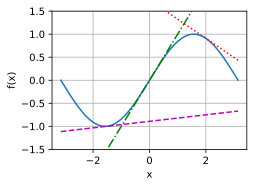

In [5]:
# Compute sin
xs = tf.range(-tf.pi, tf.pi, 0.01)
plots = [tf.sin(xs)]

# Compute some linear approximations. Use d(sin(x))/dx = cos(x)
for x0 in [-1.5, 0.0, 2.0]:
    plots.append(tf.sin(tf.constant(x0)) + (xs - x0) *
                 tf.cos(tf.constant(x0)))

d2l.plot(xs, plots, 'x', 'f(x)', ylim=[-1.5, 1.5])

### Higher Order Derivatives

Let's now do something that may on the surface seem strange.  Take a function $f$ and compute the derivative $\frac{df}{dx}$.  This gives us the rate of change of $f$ at any point.

However, the derivative, $\frac{df}{dx}$, can be viewed as a function itself, so nothing stops us from computing the derivative of $\frac{df}{dx}$ to get $\frac{d^2f}{dx^2} = \frac{df}{dx}\left(\frac{df}{dx}\right)$.  We will call this the second derivative of $f$.  This function is the rate of change of the rate of change of $f$, or in other words, how the rate of change is changing. We may apply the derivative any number of times to obtain what is called the $n$-th derivative. To keep the notation clean, we will denote the $n$-th derivative as

$$
f^{(n)}(x) = \frac{d^{n}f}{dx^{n}} = \left(\frac{d}{dx}\right)^{n} f.
$$

Let's try to understand *why* this is a useful notion.  Below, we visualize $f^{(2)}(x)$, $f^{(1)}(x)$, and $f(x)$.

First, consider the case that the second derivative $f^{(2)}(x)$ is a positive constant.  This means that the slope of the first derivative is positive.  As a result, the first derivative $f^{(1)}(x)$ may start out negative, becomes zero at a point, and then becomes positive in the end. This tells us the slope of our original function $f$ and therefore, the function $f$ itself decreases, flattens out, then increases.  In other words, the function $f$ curves up, and has a single minimum as is shown in :numref:`fig_positive-second`.

![If we assume the second derivative is a positive constant, then the fist derivative in increasing, which implies the function itself has a minimum.](http://d2l.ai/_images/posSecDer.svg)
:label:`fig_positive-second`


Second, if the second derivative is a negative constant, that means that the first derivative is decreasing.  This implies the first derivative may start out positive, becomes zero at a point, and then becomes negative. Hence, the function $f$ itself increases, flattens out, then decreases.  In other words, the function $f$ curves down, and has a single maximum as is shown in :numref:`fig_negative-second`.

![If we assume the second derivative is a negative constant, then the fist derivative in decreasing, which implies the function itself has a maximum.](http://d2l.ai/_images/negSecDer.svg)
:label:`fig_negative-second`


Third, if the second derivative is a always zero, then the first derivative will never change---it is constant!  This means that $f$ increases (or decreases) at a fixed rate, and $f$ is itself a straight line  as is shown in :numref:`fig_zero-second`.

![If we assume the second derivative is zero, then the fist derivative is constant, which implies the function itself is a straight line.](http://d2l.ai/_images/zeroSecDer.svg)
:label:`fig_zero-second`

To summarize, the second derivative can be interpreted as describing the way that the function $f$ curves.  A positive second derivative leads to a upwards curve, while a negative second derivative means that $f$ curves downwards, and a zero second derivative means that $f$ does not curve at all.

Let's take this one step further. Consider the function $g(x) = ax^{2}+ bx + c$.  We can then compute that

$$
\begin{aligned}
\frac{dg}{dx}(x) & = 2ax + b \\
\frac{d^2g}{dx^2}(x) & = 2a.
\end{aligned}
$$

If we have some original function $f(x)$ in mind, we may compute the first two derivatives and find the values for $a, b$, and $c$ that make them match this computation.  Similarly to the previous section where we saw that the first derivative gave the best approximation with a straight line, this construction provides the best approximation by a quadratic.  Let's visualize this for $f(x) = \sin(x)$.


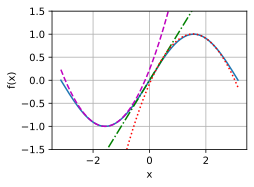

In [6]:
# Compute sin
xs = tf.range(-tf.pi, tf.pi, 0.01)
plots = [tf.sin(xs)]

# Compute some quadratic approximations. Use d(sin(x)) / dx = cos(x)
for x0 in [-1.5, 0.0, 2.0]:
    plots.append(tf.sin(tf.constant(x0)) + (xs - x0) *
                 tf.cos(tf.constant(x0)) - (xs - x0)**2 *
                 tf.sin(tf.constant(x0)) / 2)

d2l.plot(xs, plots, 'x', 'f(x)', ylim=[-1.5, 1.5])

We will extend this idea to the idea of a *Taylor series* in the next section.

### Taylor Series


The *Taylor series* provides a method to approximate the function $f(x)$ if we are given values for the first $n$ derivatives at a point $x_0$, i.e., $\left\{ f(x_0), f^{(1)}(x_0), f^{(2)}(x_0), \ldots, f^{(n)}(x_0) \right\}$. The idea will be to find a degree $n$ polynomial that matches all the given derivatives at $x_0$.

We saw the case of $n=2$ in the previous section and a little algebra shows this is

$$
f(x) \approx \frac{1}{2}\frac{d^2f}{dx^2}(x_0)(x-x_0)^{2}+ \frac{df}{dx}(x_0)(x-x_0) + f(x_0).
$$

As we can see above, the denominator of $2$ is there to cancel out the $2$ we get when we take two derivatives of $x^2$, while the other terms are all zero.  Same logic applies for the first derivative and the value itself.

If we push the logic further to $n=3$, we will conclude that

$$
f(x) \approx \frac{\frac{d^3f}{dx^3}(x_0)}{6}(x-x_0)^3 + \frac{\frac{d^2f}{dx^2}(x_0)}{2}(x-x_0)^{2}+ \frac{df}{dx}(x_0)(x-x_0) + f(x_0).
$$

where the $6 = 3 \times 2 = 3!$ comes from the constant we get in front if we take three derivatives of $x^3$.


Furthermore, we can get a degree $n$ polynomial by

$$
P_n(x) = \sum_{i = 0}^{n} \frac{f^{(i)}(x_0)}{i!}(x-x_0)^{i}.
$$

where the notation

$$
f^{(n)}(x) = \frac{d^{n}f}{dx^{n}} = \left(\frac{d}{dx}\right)^{n} f.
$$


Indeed, $P_n(x)$ can be viewed as the best $n$-th degree polynomial approximation to our function $f(x)$.

While we are not going to dive all the way into the error of the above approximations, it is worth mentioning the infinite limit. In this case, for well behaved functions (known as real analytic functions) like $\cos(x)$ or $e^{x}$, we can write out the infinite number of terms and approximate the exactly same function

$$
f(x) = \sum_{n = 0}^\infty \frac{f^{(n)}(x_0)}{n!}(x-x_0)^{n}.
$$

Take $f(x) = e^{x}$ as am example. Since $e^{x}$ is its own derivative, we know that $f^{(n)}(x) = e^{x}$. Therefore, $e^{x}$ can be reconstructed by taking the Taylor series at $x_0 = 0$, i.e.,

$$
e^{x} = \sum_{n = 0}^\infty \frac{x^{n}}{n!} = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \cdots.
$$

Let's see how this works in code and observe how increasing the degree of the Taylor approximation brings us closer to the desired function $e^x$.


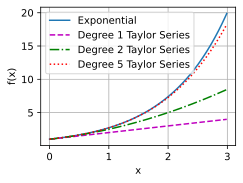

In [7]:
# Compute the exponential function
xs = tf.range(0, 3, 0.01)
ys = tf.exp(xs)

# Compute a few Taylor series approximations
P1 = 1 + xs
P2 = 1 + xs + xs**2 / 2
P5 = 1 + xs + xs**2 / 2 + xs**3 / 6 + xs**4 / 24 + xs**5 / 120

d2l.plot(xs, [ys, P1, P2, P5], 'x', 'f(x)', legend=[
    "Exponential", "Degree 1 Taylor Series", "Degree 2 Taylor Series",
    "Degree 5 Taylor Series"])

Taylor series have two primary applications:

1. *Theoretical applications*: Often when we try to understand a too complex function, using Taylor series enables us to turn it into a polynomial that we can work with directly.

2. *Numerical applications*: Some functions like $e^{x}$ or $\cos(x)$ are  difficult for machines to compute.  They can store tables of values at a fixed precision (and this is often done), but it still leaves open questions like "What is the 1000-th digit of $\cos(1)$?"  Taylor series are often helpful to answer such questions.


## Summary

* Derivatives can be used to express how functions change when we change the input by a small amount.
* Elementary derivatives can be combined using derivative rules to create arbitrarily complex derivatives.
* Derivatives can be iterated to get second or higher order derivatives.  Each increase in order provides more fine grained information on the behavior of the function.
* Using information in the derivatives of a single data example, we can approximate well behaved functions by polynomials obtained from the Taylor series.


## Exercises

1. What is the derivative of $x^3-4x+1$?
2. What is the derivative of $\log(\frac{1}{x})$?
3. True or False: If $f'(x) = 0$ then $f$ has a maximum or minimum at $x$?
4. Where is the minimum of $f(x) = x\log(x)$ for $x\ge0$ (where we assume that $f$ takes the limiting value of $0$ at $f(0)$)?


[Discussions](https://discuss.d2l.ai/t/1089)
